# Exploratory Data Analysis (EDA)
This notebook explores the underlying structure, distributions, and relationships within the dataset. The insights gained will inform data cleaning, preprocessing decisions, and model selection for the regression task.

## Key Questions Addressed
1. Is the target variable suitable for regression without transformation?
2. Are there data quality issues (missing values, duplicates, impossible values)?
3. Are features on compatible scales?
4. Which features have the strongest relationships with the outcome?
5. Is multicollinearity present among predictors?
6. Are categorical variables ordinal or nominal?
7. Do any numerical features require transformation due to skewness?

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

In [28]:
df = pd.read_csv("../data/CW1_train.csv")

## 1. Dataset Overview

In [29]:
print("Dataset shape:", df.shape)

numerical_features = df.select_dtypes(include="number")
categorical_features = df.select_dtypes(exclude="number")

print(f"Number of numerical features: {len(numerical_features.columns.tolist())}")
print(f"Number of categorical features: {len(categorical_features.columns.tolist())}")

print("\nNumerical features:")
print(numerical_features.columns.tolist())

print("\nCategorical features:")
print(categorical_features.columns.tolist())

print("\nTarget (outcome) summary:")
print(df["outcome"].describe())


Dataset shape: (10000, 31)
Number of numerical features: 28
Number of categorical features: 3

Numerical features:
['outcome', 'carat', 'depth', 'table', 'price', 'x', 'y', 'z', 'a1', 'a2', 'a3', 'a4', 'a5', 'b1', 'b2', 'b3', 'b4', 'b5', 'a6', 'a7', 'a8', 'a9', 'a10', 'b6', 'b7', 'b8', 'b9', 'b10']

Categorical features:
['cut', 'color', 'clarity']

Target (outcome) summary:
count    10000.000000
mean        -4.979081
std         12.722224
min        -44.879471
25%        -13.989962
50%         -5.442794
75%          3.918593
max         39.675966
Name: outcome, dtype: float64


**Key Findings:**
- Dataset contains 10,000 samples with 30 features and 1 target
- Predominantly numerical (28 features), with only 3 categorical features
- Categorical features (cut, color, clarity) will require appropriate encoding

## 2. Data Quality Assessment

In [30]:
print("Missing values per column:")
print(df.isnull().sum())

print("Number of duplicate rows:", df.duplicated().sum())

Missing values per column:
outcome    0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
a1         0
a2         0
a3         0
a4         0
a5         0
b1         0
b2         0
b3         0
b4         0
b5         0
a6         0
a7         0
a8         0
a9         0
a10        0
b6         0
b7         0
b8         0
b9         0
b10        0
dtype: int64
Number of duplicate rows: 0


In [31]:
print("Number of zero/non-negative values in dimensions:")
print((df[["x", "y", "z"]] <= 0).sum())

print("Summary statistics for dimensions:")
print(df[["x", "y", "z"]].describe())

Number of zero/non-negative values in dimensions:
x    2
y    2
z    4
dtype: int64
Summary statistics for dimensions:
                  x             y             z
count  10000.000000  10000.000000  10000.000000
mean       5.733974      5.741665      3.540757
std        1.114850      1.228057      0.692502
min        0.000000      0.000000      0.000000
25%        4.730000      4.740000      2.920000
50%        5.700000      5.720000      3.530000
75%        6.530000      6.530000      4.030000
max       10.010000     58.900000      8.060000


**Physical Dimension Validation:**

Physical dimensions (x, y, z) must be positive non-zero values by definition. The analysis identified:

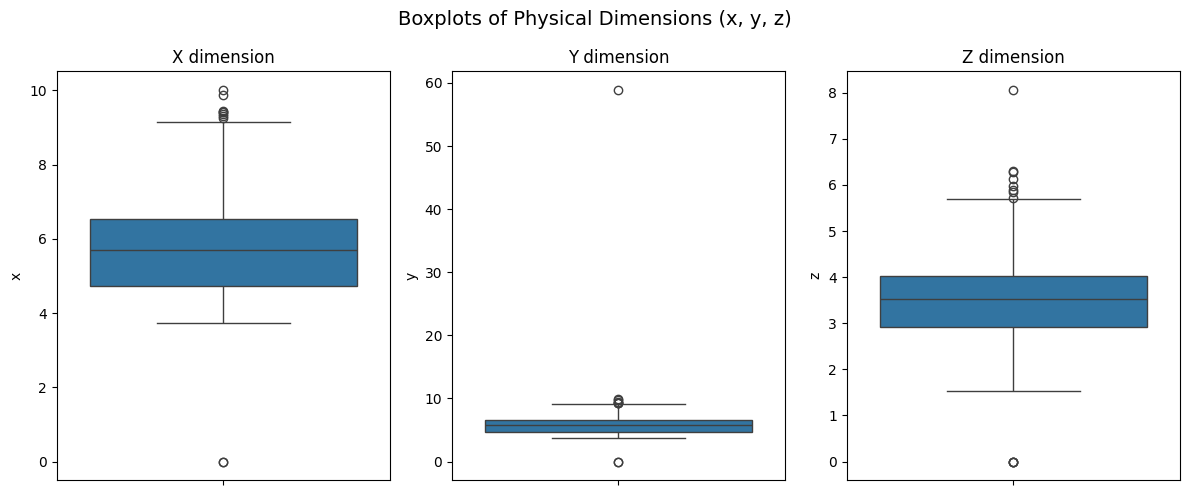

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

sns.boxplot(data=df["x"], ax=axes[0])
axes[0].set_title("X dimension")

sns.boxplot(data=df["y"], ax=axes[1])
axes[1].set_title("Y dimension")

sns.boxplot(data=df["z"], ax=axes[2])
axes[2].set_title("Z dimension")

fig.suptitle("Boxplots of Physical Dimensions (x, y, z)", fontsize=14)
plt.tight_layout()
plt.savefig("../figures/dimension_boxplots.png", dpi=300, bbox_inches="tight")
plt.show()

**Findings:**
- No missing values detected across the entire dataset
- No duplicate rows identified
- **Data quality issue:** Zero values found in physical dimensions
- **Outlier:** The y dimension contains a value of ~59 (max 58.9)

These observations suggest potential data entry errors or measurement anomalies requiring correction before model training.

## 3. Target Variable Distribution

Skewness of outcome: 0.0831


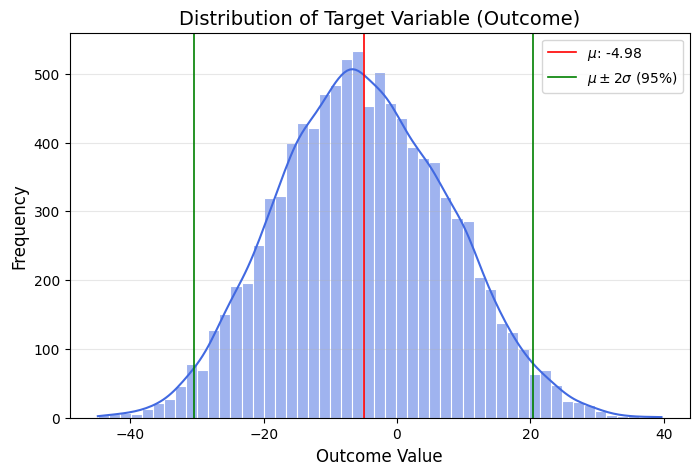

In [33]:
plt.figure(figsize=(8, 5))

mu = df["outcome"].mean()
sigma = df["outcome"].std()
skewness = df["outcome"].skew()

print(f"Skewness of outcome: {skewness:.4f}")

sns.histplot(df["outcome"], kde=True, color="royalblue", edgecolor="white")

plt.title("Distribution of Target Variable (Outcome)", fontsize=14)
plt.xlabel("Outcome Value", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis="y", alpha=0.3)

plt.axvline(x=mu, color="red", linewidth=1.2, label=rf"$\mu$: {mu:.2f}")
plt.axvline(x=mu + 2*sigma, linewidth=1.2, color="green", label=r"$\mu \pm 2\sigma$ (95%)")
plt.axvline(x=mu - 2*sigma, linewidth=1.2, color="green")

plt.legend()

plt.savefig("../figures/target_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

**Analysis:**

The target variable (outcome) exhibits an approximately normal distribution with the following characteristics:

- **Mean (μ):** -4.98
- **Skewness:** 0.08 (near-zero indicates symmetry)
- **Distribution shape:** Bell-shaped and symmetric around the mean
- **Spread:** Approximately 95% of values fall within ±2σ of the mean
- **Tail behavior:** Frequencies taper smoothly toward extremes (≈ -40 to +40), consistent with natural variation rather than anomalous outliers

**Conclusion:** The target variable is well-suited for standard regression modeling without requiring transformations

## 4. Correlation Analysis & Multicollinearity

### 4.1 Pearson Correlation Matrix

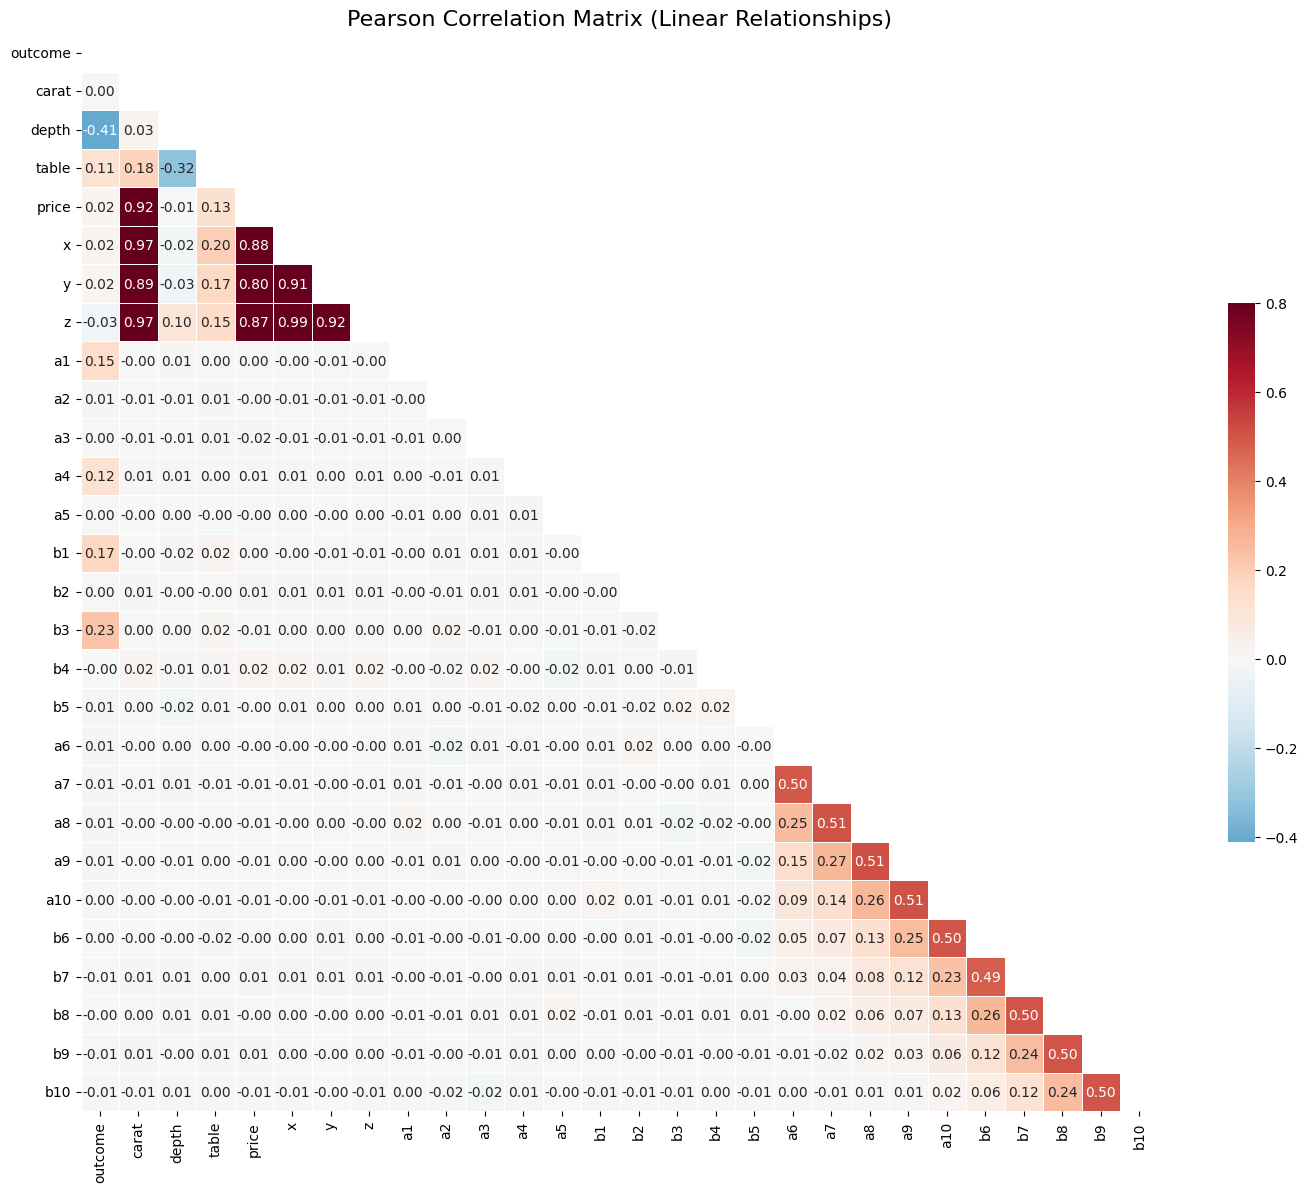

In [34]:
correlation_matrix = numerical_features.corr(method="pearson")
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

fig, axes = plt.subplots(figsize=(18, 14))

sns.heatmap(
    correlation_matrix, 
    mask=mask, 
    cmap='RdBu_r', 
    vmax=.8, 
    center=0,       
    square=True,
    linewidths=.5,
    annot=True,
    fmt=".2f",
    cbar_kws={"shrink": .5}
)

plt.title("Pearson Correlation Matrix (Linear Relationships)", fontsize=16)
plt.savefig("../figures/correlation_heatmap.png", bbox_inches='tight', dpi=300)
plt.show()

**Purpose:** Pearson correlation identifies **linear relationships** between features and detects potential multicollinearity that could affect model stability.

**Key Observations:**
- Strong positive correlations exist among carat, price, and physical dimensions (x, y, z)
- Depth shows notable correlation with the outcome variable
- Multicollinearity among dimension-related features may require regularization strategies

### 4.2 Feature-Outcome Relationships (Spearman Correlation)

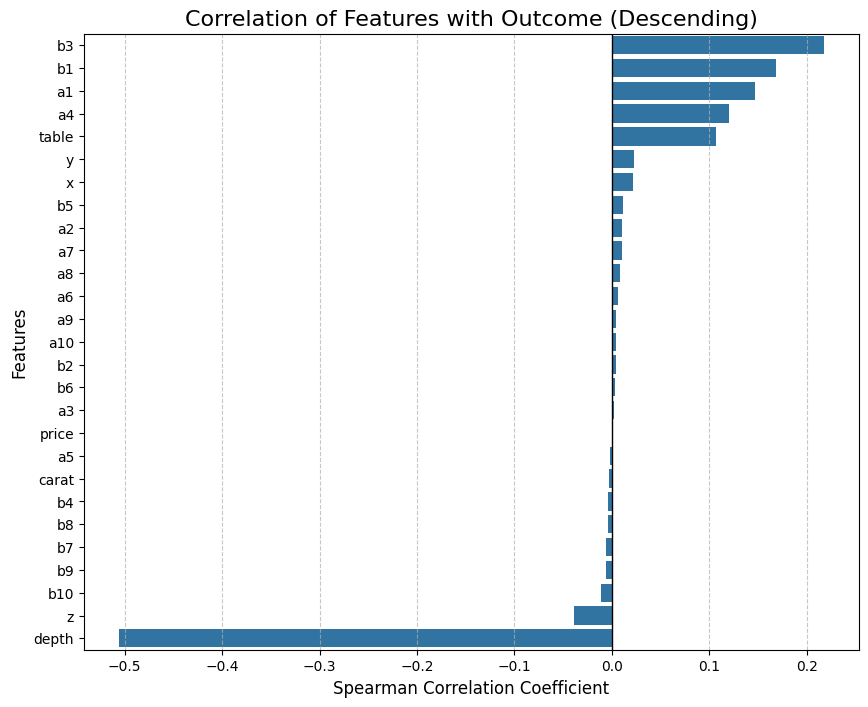

In [35]:
correlations = numerical_features.corr(method="spearman")["outcome"].drop("outcome").sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=correlations.values, y=correlations.index, legend=False)

plt.title("Correlation of Features with Outcome (Descending)", fontsize=16)
plt.xlabel("Spearman Correlation Coefficient", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.axvline(x=0, color="black", linestyle="-", linewidth=1)
plt.grid(axis="x", linestyle="--", alpha=0.7)


plt.savefig("../figures/target_correlations_bar.png", bbox_inches="tight", dpi=300)
plt.show()

**Purpose:** Spearman correlation captures **monotonic relationships** (both linear and non-linear) between features and the outcome.

**Top Predictors by Absolute Correlation:**

In [36]:
n = 5
correlation = numerical_features.corr(method="spearman")["outcome"].drop("outcome")
top_features = correlation.abs().sort_values(ascending=False).head(n)
print(f"Top {n} features by Spearman correlation with outcome:")
print(correlation[top_features.index])

Top 5 features by Spearman correlation with outcome:
depth   -0.505889
b3       0.217254
b1       0.168709
a1       0.146819
a4       0.120144
Name: outcome, dtype: float64


**Rationale for Dual Correlation Analysis:**
- **Pearson:** Detects linear relationships, essential for linear models
- **Spearman:** Captures monotonic patterns that may be non-linear
- Together, they provide comprehensive insight into feature-outcome relationships

The top 5 features identified above are now examined visually to confirm the nature of their relationships with the outcome.

## 5. Feature-Outcome Relationships: Visual Analysis

To assess the nature of relationships between top predictors and the outcome, scatter plots with linear regression lines are examined:

In [37]:
def plot_feature_vs_outcome(feature: str, data=None):
    if data is None:
        data = df
    data = data.dropna(subset=[feature, "outcome"])
    r, _ = stats.pearsonr(data[feature], data["outcome"])
    slope = np.cov(data[feature], data["outcome"])[0, 1] / np.var(data[feature])
    intercept = data["outcome"].mean() - slope * data[feature].mean()
    y_pred = slope * data[feature] + intercept
    r_squared = 1 - np.sum((data["outcome"] - y_pred) ** 2) / np.sum((data["outcome"] - data["outcome"].mean()) ** 2)
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=feature, y="outcome", data=data, alpha=0.5)
    sns.regplot(x=feature, y="outcome", data=data, scatter=False, color="red")
    plt.title(f"{feature} vs Outcome (r = {r:.3f}, R\u00b2 = {r_squared:.3f})")
    plt.xlabel(feature)
    plt.ylabel("Outcome")
    plt.savefig(f"../figures/scatter_plot_{feature}_vs_outcome.png", dpi=300, bbox_inches="tight")
    plt.show()

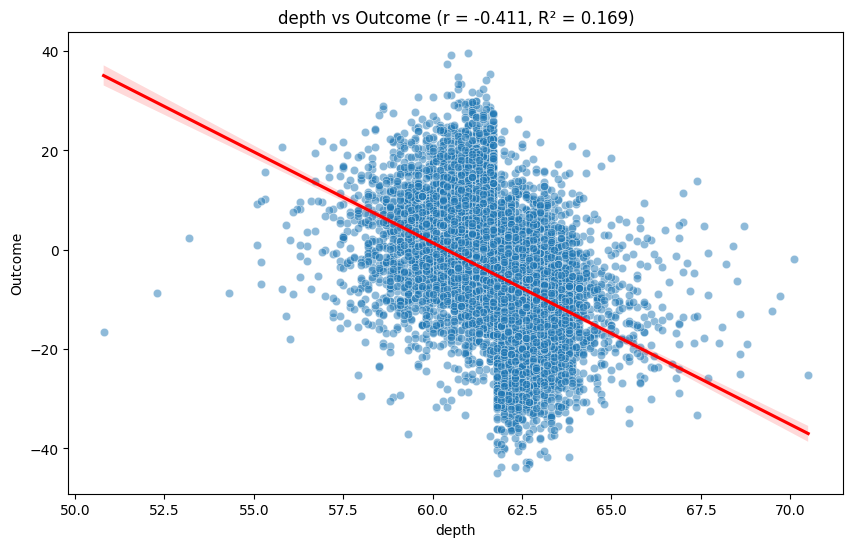

In [38]:
plot_feature_vs_outcome("depth")

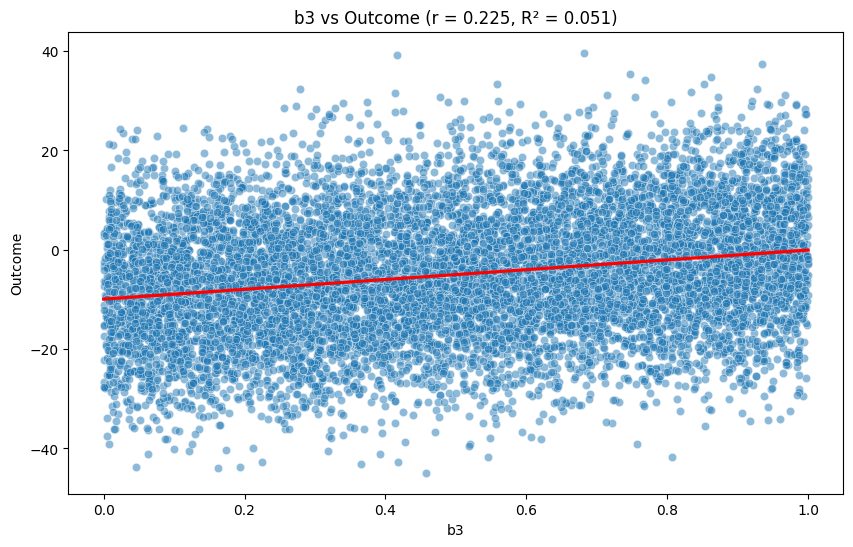

In [39]:
plot_feature_vs_outcome("b3")

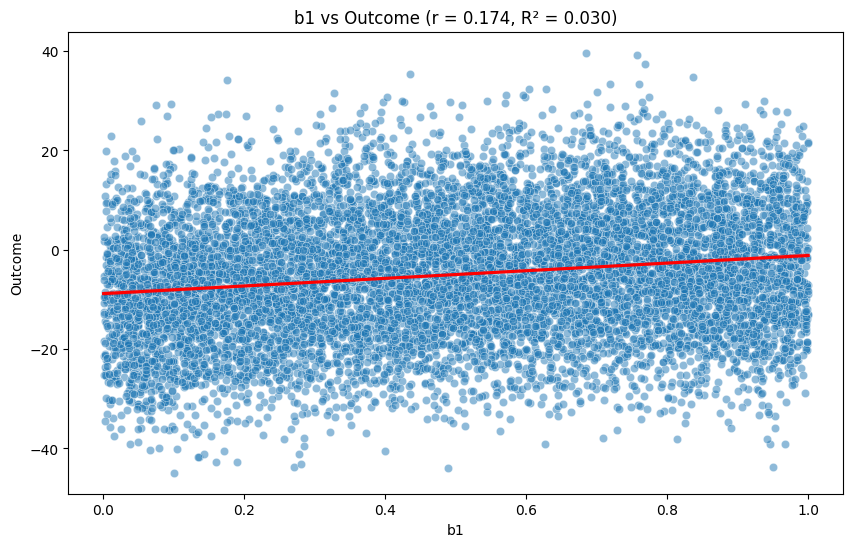

In [40]:
plot_feature_vs_outcome("b1")

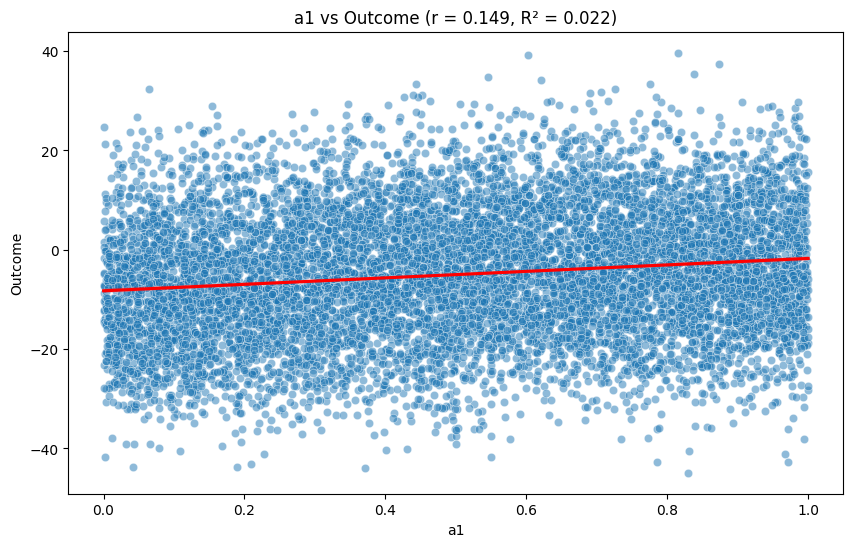

In [41]:
plot_feature_vs_outcome("a1")

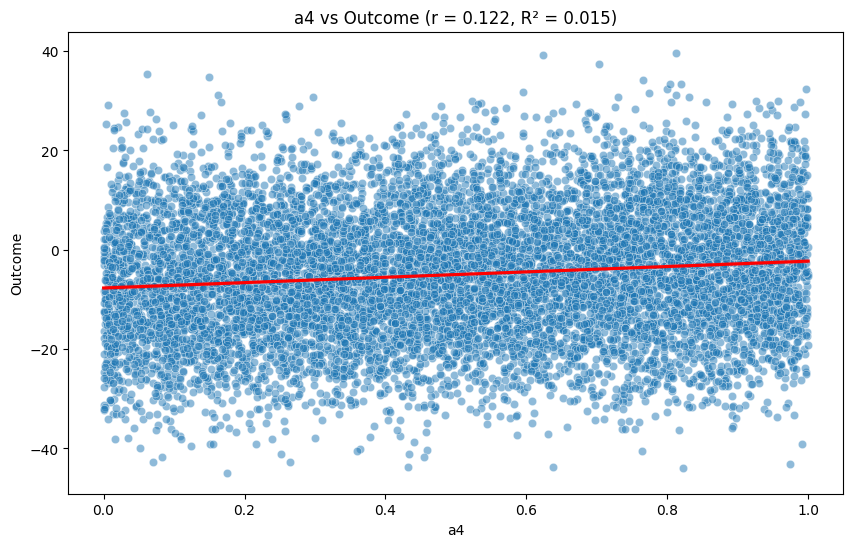

In [42]:
plot_feature_vs_outcome("a4")

**Interpretation:**

The scatter plots reveal approximately linear relationships between the top features and the outcome:
- **depth:** Strongest linear trend (highest R²)
- **b3, b1, a1, a4:** Moderate to strong linear patterns

## 6. Categorical Features Analysis

### Ordinal Nature of Categorical Variables

The three categorical features have inherent quality orderings:

- **Cut:** Fair < Good < Very Good < Premium < Ideal
- **Color:** D (best) → J (worst)
- **Clarity:** I1 (worst) → IF (best)

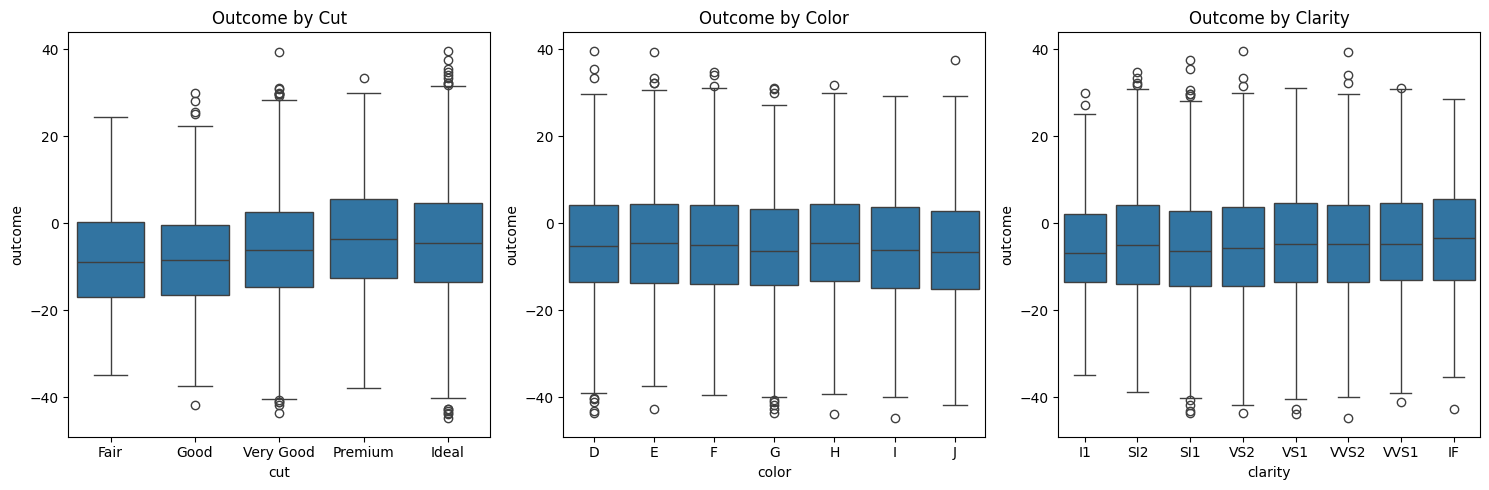

In [43]:
cut_order = ["Fair", "Good", "Very Good", "Premium", "Ideal"]
color_order = ["D", "E", "F", "G", "H", "I", "J"]
clarity_order = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.boxplot(x="cut", y="outcome", data=df, ax=axes[0], order=cut_order)
axes[0].set_title("Outcome by Cut")

sns.boxplot(x="color", y="outcome", data=df, ax=axes[1], order=color_order)
axes[1].set_title("Outcome by Color")

sns.boxplot(x="clarity", y="outcome", data=df, ax=axes[2], order=clarity_order)
axes[2].set_title("Outcome by Clarity")

plt.tight_layout()
plt.savefig("../figures/categorical_boxplots.png", dpi=300, bbox_inches="tight")
plt.show()


**Encoding Strategy:**

Since cut, color, and clarity are **ordinal variables** with meaningful quality rankings:

- **Recommended:** Ordinal (label) encoding to preserve order information
  - Maps quality levels to integers (e.g., Fair=1, Good=2, ..., Ideal=5)
  - Allows models to leverage the inherent ordering
  - Particularly beneficial for linear models and tree-based algorithms

- **Not recommended:** One-hot encoding
  - Would discard valuable ordering information
  - Would unnecessarily inflate dimensionality (9+ new binary columns)
  - Appropriate only for nominal (unordered) categories

## 7. Feature Scaling and Skewness Assessment

### 7.1 Scale Variability

In [44]:
df.describe().T[["mean", "std", "min", "max"]]

,mean,std,min,max
outcome,-4.979081,12.722224,-44.879471,39.675966
carat,0.798407,0.472046,0.200000,4.000000
depth,61.748060,1.429631,50.800000,70.500000
table,57.467360,2.247036,44.000000,73.000000
price,3910.841900,3940.369616,326.000000,18791.000000
x,5.733974,1.114850,0.000000,10.010000
y,5.741665,1.228057,0.000000,58.900000
z,3.540757,0.692502,0.000000,8.060000
a1,0.502349,0.291012,0.000128,0.999789
a2,0.507509,0.291207,0.000101,0.999976


**Observation:** Features exist on vastly different scales (e.g., price in thousands, depth as percentages). Standardization will be necessary for distance-based and regularized models.

### 7.2 Skewness Analysis

In [45]:
numerical_features.skew().sort_values(ascending=False)

y          8.372088
price      1.633379
carat      1.153380
table      0.721103
x          0.373087
z          0.364712
outcome    0.083080
b10        0.019527
b5         0.012293
b6         0.007632
a5         0.007531
b3         0.003986
b2         0.000515
a6        -0.000117
b1        -0.000258
a3        -0.003662
b4        -0.007648
b9        -0.009831
a1        -0.010857
a10       -0.015344
a4        -0.019157
a9        -0.020444
a2        -0.027996
a7        -0.033658
b8        -0.034361
a8        -0.034436
b7        -0.058334
depth     -0.230483
dtype: float64

**Right-Skewed Features:**

Several features exhibit strong positive skewness (>1.0), indicating long right tails:

Skewness of price: 1.6334. Right-skewed (positive) distributions often benefit from log transformation to reduce skew and stabilize variance.


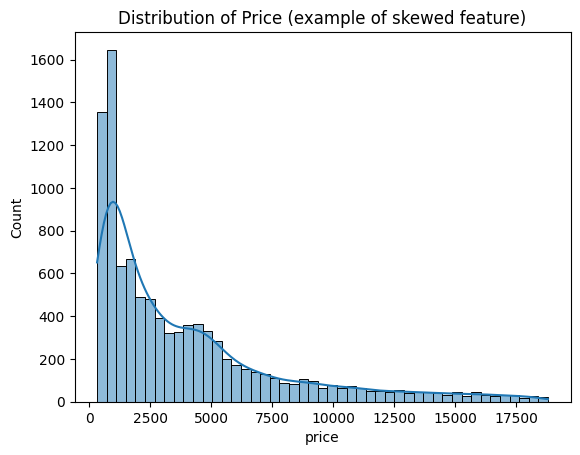

In [46]:
price_skew = df["price"].skew()
print(f"Skewness of price: {price_skew:.4f}. Right-skewed (positive) distributions often benefit from log transformation to reduce skew and stabilize variance.")
sns.histplot(df["price"], kde=True)
plt.title("Distribution of Price (example of skewed feature)")
plt.savefig("../figures/price_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

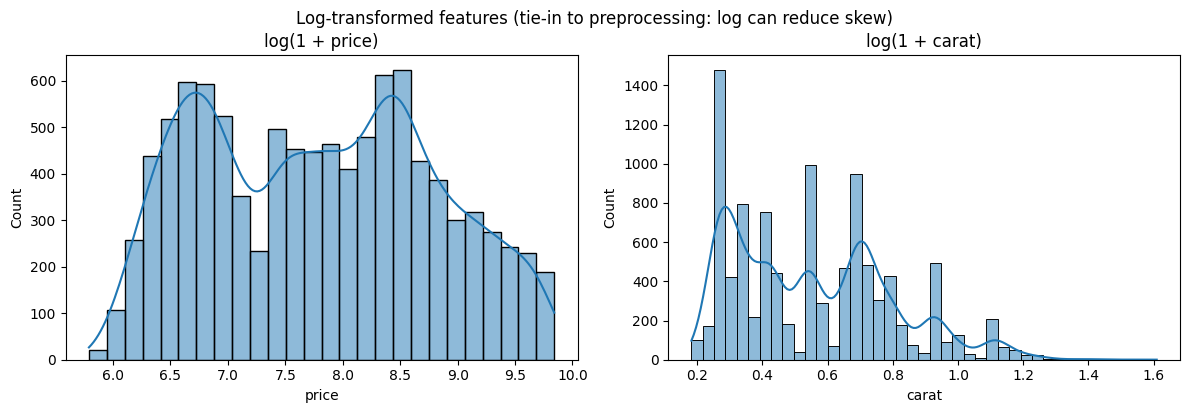

In [47]:
# Log(price) reduces right-skew; useful if we log-transform price in preprocessing.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(np.log1p(df["price"]), kde=True, ax=ax1)
ax1.set_title("log(1 + price)")
sns.histplot(np.log1p(df["carat"]), kde=True, ax=ax2)
ax2.set_title("log(1 + carat)")
plt.tight_layout()
plt.suptitle("Log-transformed features (tie-in to preprocessing: log can reduce skew)", y=1.02)
plt.savefig("../figures/log_transformed_features.png", dpi=300, bbox_inches="tight")
plt.show()

**Impact of Skewness:**
- Violates normality assumptions in linear regression
- Can lead to heteroscedasticity (non-constant variance)
- May reduce model performance and interpretability

**Transformation Strategy:**

Log transformation (log(1 + x)) is recommended for highly skewed features:
- Reduces skewness toward symmetry
- Stabilizes variance across the feature range
- Commonly applied to price and carat in regression contexts

### 7.3 Data Cleaning: Removing Invalid Dimensions

Removed 5 rows due to invalid dimensions (x<=0, y<=0, z<=0, or y>10).


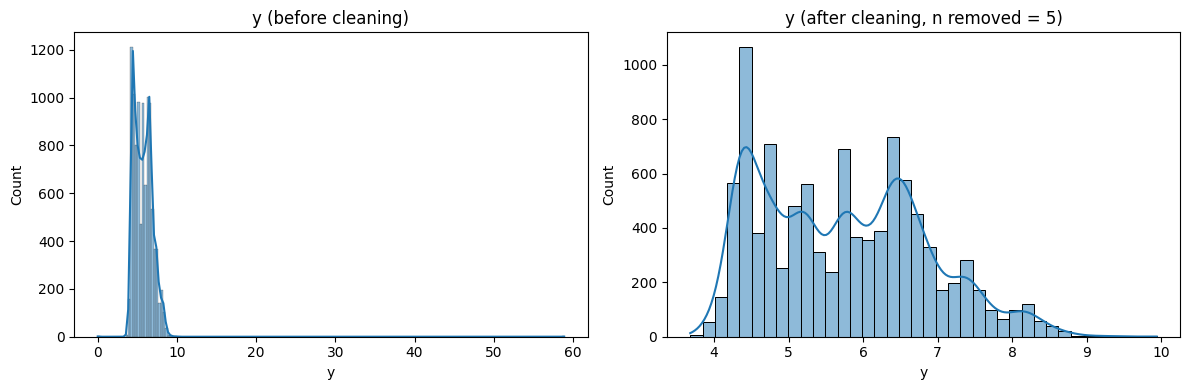

In [48]:
df_clean = df[(df["x"] > 0) & (df["y"] > 0) & (df["z"] > 0) & (df["y"] <= 10)]
n_removed = len(df) - len(df_clean)
print(f"Removed {n_removed} rows due to invalid dimensions (x<=0, y<=0, z<=0, or y>10).")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df["y"], kde=True, ax=ax1)
ax1.set_title("y (before cleaning)")
sns.histplot(df_clean["y"], kde=True, ax=ax2)
ax2.set_title(f"y (after cleaning, n removed = {n_removed})")
plt.tight_layout()
plt.savefig("../figures/y_distribution_before_after.png", dpi=300, bbox_inches="tight")
plt.show()

**Cleaning Criteria:**
- **x > 0, y > 0, z > 0:** Ensures physical plausibility (all dimensions must be positive)
- **y ≤ 10:** Removes extreme outlier inconsistent with diamond dimensions

**Result:** Removed `n_removed` rows, yielding a cleaned dataset for modeling.


## 8. Summary and Preprocessing Plan

### Key Findings

| Finding | Evidence | Implication |
|:--------|:---------|:------------|
| **No missing data** | `df.isnull().sum() == 0` | No imputation required |
| **Invalid physical dimensions** | Zero values and extreme y (~59) outlier | Data cleaning necessary |
| **Symmetric target distribution** | Skewness ≈ 0.08 | No outcome transformation needed |
| **Strong multicollinearity** | Correlation heatmap | Regularization (Lasso/Ridge) recommended |
| **Clear top predictors** | Spearman correlation ranking | Prioritize depth, b3, b1, a1, a4 |
| **Ordinal categorical features** | Quality-ordered levels | Use ordinal encoding |
| **Right-skewed numerical features** | Skewness > 1 for price, carat, table | Apply log transformation |
| **Inconsistent feature scales** | Summary statistics | Apply StandardScaler |

### Preprocessing Pipeline

Based on the EDA findings, the following preprocessing steps will be implemented:

1. **Data Cleaning**
   - Remove rows where x ≤ 0, y ≤ 0, z ≤ 0, or y > 10
   - Verify no remaining physically impossible values

2. **Feature Engineering**
   - Apply log(1 + x) transformation to highly skewed features (price, carat, table)
   - Encode categorical features using ordinal mapping based on quality rankings

3. **Scaling**
   - Apply StandardScaler to all numerical features
   - Ensures equal contribution in distance-based and regularized models

4. **Multicollinearity Handling**
   - Use regularization (Ridge/Lasso) to mitigate correlated predictors
   - Introduce engineered features
   - Consider dimensionality reduction (PCA) if necessary
---

**All models will be trained on the cleaned dataset (`df_clean`) to ensure physical plausibility and robust predictions.**